<center><h1>1-ab: SIFT & BoW</h1></center>

<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.



In [ ]:
#%%capture
!wget http://webia.lip6.fr/~dancette/deep-learning/assets/TP1-2-data.zip
!unzip TP1-2-data.zip

!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/1-ab/tools.py

--2021-09-29 14:08:20--  http://webia.lip6.fr/~dancette/deep-learning/assets/TP1-2-data.zip
Resolving webia.lip6.fr (webia.lip6.fr)... 132.227.201.33
Connecting to webia.lip6.fr (webia.lip6.fr)|132.227.201.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86446976 (82M) [application/zip]
Saving to: ‘TP1-2-data.zip’

TP1-2-data.zip      100%[===================>]  82.44M  25.5MB/s    in 3.2s    

2021-09-29 14:08:23 (25.5 MB/s) - ‘TP1-2-data.zip’ saved [86446976/86446976]

Archive:  TP1-2-data.zip
   creating: data/
   creating: data/Scene/
   creating: data/Scene/PARoffice/
 extracting: data/Scene/PARoffice/image_0091.jpg  
 extracting: data/Scene/PARoffice/image_0167.jpg  
  inflating: data/Scene/PARoffice/image_0037.jpg  
 extracting: data/Scene/PARoffice/image_0135.jpg  
 extracting: data/Scene/PARoffice/image_0015.jpg  
 extracting: data/Scene/PARoffice/image_0182.jpg  
 extracting: data/Scene/PARoffice/image_0064.jpg  
 extracting: data/Scene/PARoffice/im

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import numpy as np
%run 'tools.py'
from os.path import join

data_path = "data"

# Part 1 : SIFT

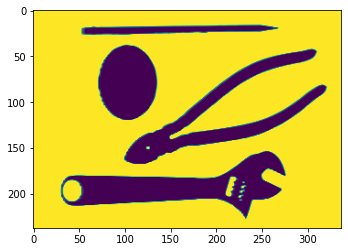

In [ ]:
# example images
I = read_grayscale(join(data_path, 'tools.tiff'))
I2 = read_grayscale(join(data_path, 'Scene/CALsuburb/image_0205.jpg'))
plt.imshow(I)

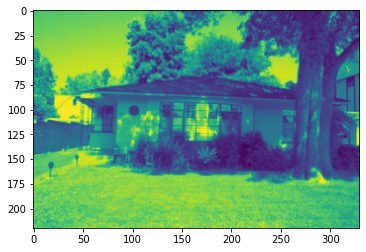

In [ ]:
plt.imshow(I2)

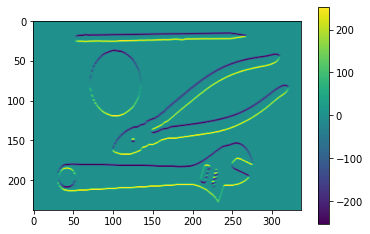

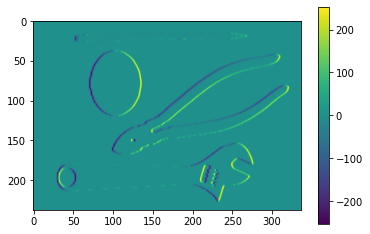

In [ ]:
def compute_grad(I):
  ha = 0.5*np.array([1,2,1])
  hb = 0.5*np.array([-1,0,1])
  Ix = conv_separable(I, ha, hb)
  Iy = conv_separable(I, hb, ha)
  return Ix, Iy

# Example
Ix, Iy = compute_grad(I)
plt.imshow(Ix)
plt.colorbar()
plt.show()
plt.imshow(Iy)
plt.colorbar()
plt.show()

In [ ]:
def compute_grad_mod_ori(I):
  Ix, Iy = compute_grad(I)
  Gn = np.sqrt(Ix**2 + Iy**2)
  Go = compute_grad_ori(Ix, Iy, Gn)   # la fonction est déjà discrétisée
  return Gn, Go

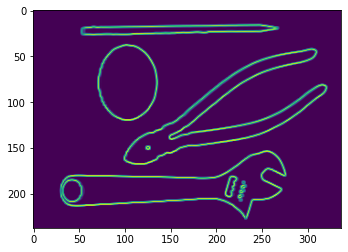

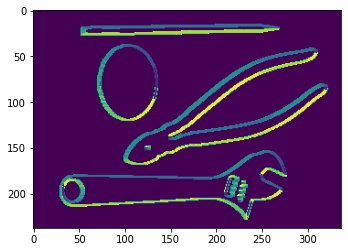

In [ ]:
Gn, Go = compute_grad_mod_ori(I)
plt.imshow(Gn)
plt.show()
plt.imshow(Go)
plt.show()

In [ ]:
Go.shape

(238, 337)

In [ ]:
def compute_histogram(g_n, g_o):
    """
    g_n and g_o are 4x4 matrices that contain the norm, and the discretized orientation.
    Warning: g_o can contain -1, those values should be discarded.
    """
    """histogram of ONE SQUARE within the patch"""
    hist = np.zeros((8))
    g_n, g_o = g_n.flatten(),  g_o.flatten()
    for i in range(0, 8):
      hist[i] = sum([norm for norm, orientation in zip(g_n, g_o) if orientation == i and norm != -1])
    return hist
  

In [ ]:
def compute_sift_region(Gn, Go, mask=None):
    t_min=.5
    t_max=.2
    with_l2 = True

    patch_size = 16
    sift = np.zeros((128)) 

    if mask is not None:
        Gn = Gn * mask
    
    idx = 0
    for k in range(0, patch_size, 4):
        for l in range(0, patch_size, 4):
            hist = compute_histogram(Gn[l:l+4,k:k+4], Go[l:l+4,k:k+4])            
            sift[idx:idx+8] = hist
            idx += 8

    norm = np.linalg.norm(sift, ord=2)
    # min thresholding on norm
    if norm <= t_min:
        return np.zeros((128))
    # l2-normalization
    if with_l2:
        sift = sift / norm
    # max thresholding on values
    sift[sift >= t_max] = t_max
    # l2-normalization
    if with_l2:
        norm = np.linalg.norm(sift, ord=2)
        sift = sift / norm
    return sift

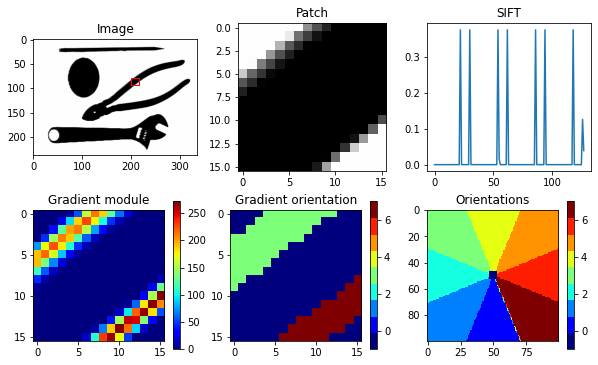

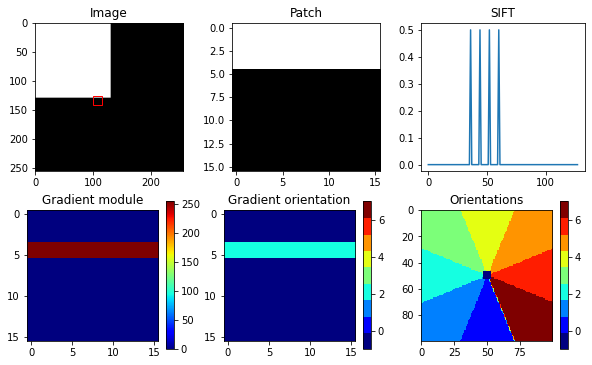

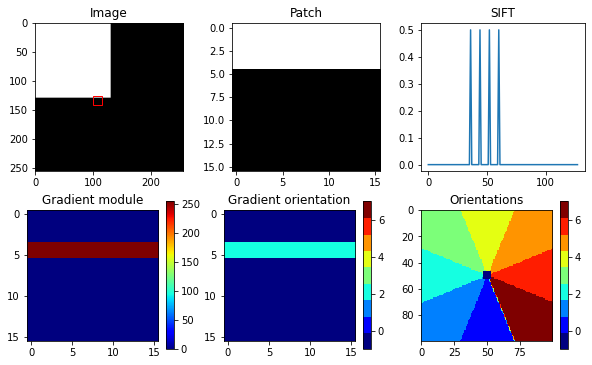

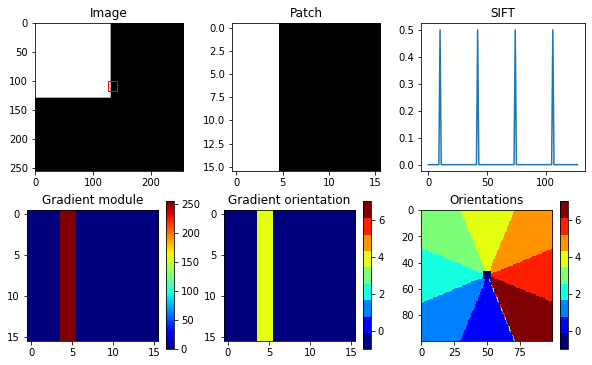

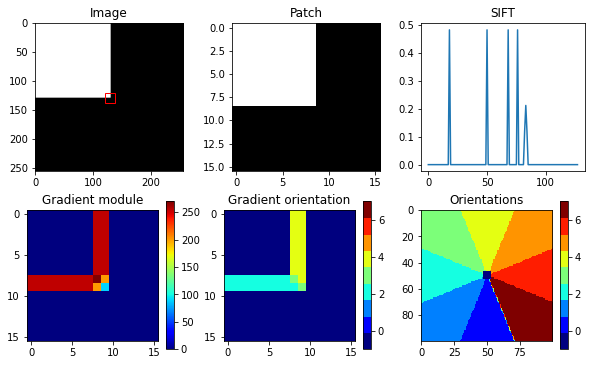

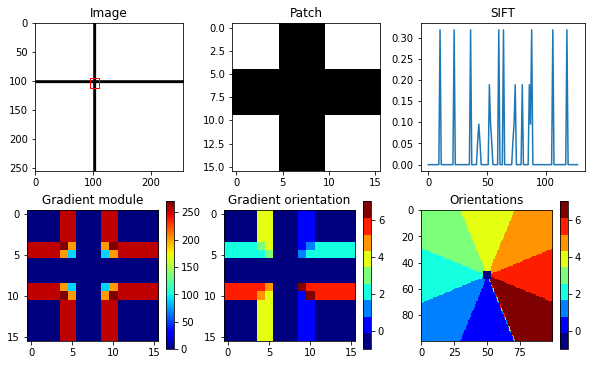

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3181317 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.3181317 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.3181317 , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05344409, 0.09560369, 0.05344409,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.18864812, 0.09560369, 0.05344409,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3181317 , 0.        , 0.        , 0.        , 0.3181317 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05344409, 0.09560369, 0.18864

In [ ]:
# Example of viz of SIFTs
# set gausm to True to apply mask weighting of gradients
display_sift_region(I,           compute_grad_mod_ori, compute_sift_region, x=200, y=78, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=100, y=125, gausm=True)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=125, y=100, gausm=False)
display_sift_region(marche_im(), compute_grad_mod_ori, compute_sift_region, x=121, y=121, gausm=False)
display_sift_region(toy_im(),    compute_grad_mod_ori, compute_sift_region, x=95, y=95, gausm=False)

In [ ]:
def compute_sift_image(I):
    x, y = dense_sampling(I)
    im = auto_padding(I)
    m = gaussian_mask()
    
    # Here, compute on the global image (norm, gradients)
    Gn, Go = compute_grad_mod_ori(I)

    sifts = np.zeros((len(x), len(y), 128))
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):

            sifts[i, j, :] = compute_sift_region(Gn, Go) # TODO SIFT of the patch of coords (xi, yj)

    return sifts

# Compute SIFT

The computation can take several minutes.

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
max_images_per_class = 10  # You can change this to None to compute the whole dataset (takes quite some time)

save_path = "/content/gdrive/My Drive/rdfia/"
dir_sc = os.path.join(data_path, 'Scene')
dir_sift = os.path.join(save_path, 'sift')
inames, ilabls, cnames = load_dataset(dir_sc, images_per_class=max_images_per_class)
sifts_list_by_image = compute_load_sift_dataset(dir_sc, dir_sift, inames, compute_sift_image)

Computing or loading SIFTs
1/150
2/150
3/150
4/150
5/150
6/150
7/150
8/150
9/150
10/150
11/150
12/150
13/150
14/150
15/150
16/150
17/150
18/150
19/150
20/150
21/150
22/150
23/150
24/150
25/150
26/150
27/150
28/150
29/150
30/150
31/150
32/150
33/150
34/150
35/150
36/150
37/150
38/150
39/150
40/150
41/150
42/150
43/150
44/150
45/150
46/150
47/150
48/150
49/150
50/150
51/150
52/150
53/150
54/150
55/150
56/150
57/150
58/150
59/150
60/150
61/150
62/150
63/150
64/150
65/150
66/150
67/150
68/150
69/150
70/150
71/150
72/150
73/150
74/150
75/150
76/150
77/150
78/150
79/150
80/150
81/150
82/150
83/150
84/150
85/150
86/150
87/150
88/150
89/150
90/150
91/150
92/150
93/150
94/150
95/150
96/150
97/150
98/150
99/150
100/150
101/150
102/150
103/150
104/150
105/150
106/150
107/150
108/150
109/150
110/150
111/150
112/150
113/150
114/150
115/150
116/150
117/150
118/150
119/150
120/150
121/150
122/150
123/150
124/150
125/150
126/150
127/150
128/150
129/150
130/150
131/150
132/150
133/150
134/150
135/150
1

# Part 2 : Visual dictionnary

In [ ]:
from sklearn.cluster import KMeans

path_vdict = os.path.join(save_path, 'kmeans', 'vdict.npy')
os.makedirs(os.path.join(save_path, 'kmeans'), exist_ok=True)

In [ ]:
# Code here the `compute_visual_dict` function
def compute_visual_dict(sift, n_clusters=1000, n_init=1, verbose=1):
    # reorder data
    dim_sift = sift[0].shape[-1]
    sift = [s.reshape(-1, dim_sift) for s in sift]
    sift = np.concatenate(sift, axis=0)
    # remove zero vectors
    keep = ~np.all(sift==0, axis=1)
    sift = sift[keep]
    # randomly pick sift
    ids, _ = compute_split(sift.shape[0], pc=0.05)
    sift = sift[ids]

    # TODO compute kmeans on `sift`, get cluster centers, add zeros vector, and return visual dict
    kmeans = KMeans(n_clusters=n_clusters, init='random', random_state=0).fit(sift)

    vdict = np.concatenate((kmeans.cluster_centers_, np.zeros((1,128))))

    return vdict


In [ ]:
# Run the visual dict computation (saved the first time)
vdict = compute_or_load_vdict(dir_sc, dir_sift, inames, compute_sift_image, path_vdict, compute_visual_dict)
print(vdict)   # if you've already run this cell before, 
               # make sure to delete the file "/kmeans/vdict.npy" or else it will just open the old file

In [ ]:
# Study of the dict

# choose random images
indexes = np.random.randint(0, len(inames), 30)
sifts = [sifts_list_by_image[i] for i in indexes]
chosen_inames = [inames[i] for i in indexes]

regions, sifts = get_regions_and_sifts(dir_sc, chosen_inames, sifts) # Compute SIFT and regions from 30 random images
# display_images(regions[np.random.choice(len(regions), 100)]) # Show 100 random regions

centers = list(range(20))
for center in centers:
  center_vect = vdict[center]
  dist = ((sifts - center_vect)**2).sum(axis=1)
  # get best 100
  top100 = dist.argsort()[:100]
  top100_regions = regions[top100]
  display_images(top100_regions) # Show 100 random regions

Output hidden; open in https://colab.research.google.com to view.

# Partie 3 : BoW

In [ ]:
# TODO Compute BoW for an image
# indication: scipy.spatial.distance_matrix
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial import distance_matrix

def compute_feats(vdict, image_sifts):
    """
    vdict: (num_clusters, 128): visual dictionnary containing all clusters.
    image_sifts: (H, W, 128) all sift features from the given image
    """
    # flatten sifts
    sifts = image_sifts.reshape(-1, 128)  # (N, 128)
    feats = np.zeros(vdict.shape[0])

    ##################### 
    ## Your code here  ##
    #####################
    # compute distance from image sifts to vdict

  
    ####################
    ##      END        #
    ####################
    return feats

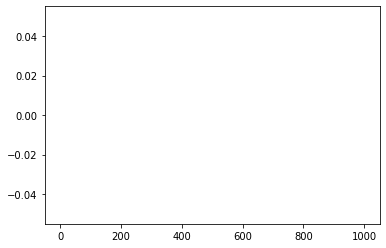

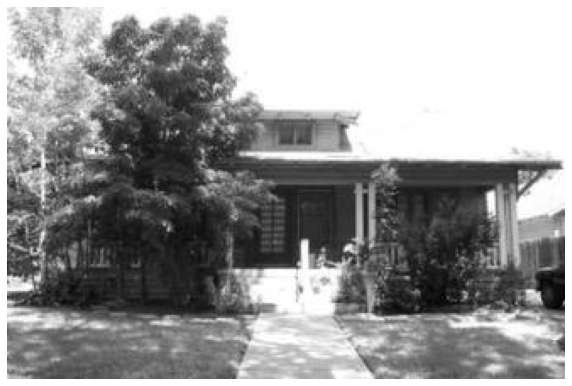

(9, 16, 16)


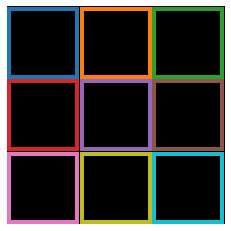

In [ ]:
# Visualize your BoW on an image

iname = inames[0]
ipath = os.path.join(dir_sc, iname)
im = read_grayscale(ipath)
sift = compute_sift_image(im)
sift = (sift * 255).astype('uint8')
regions = compute_regions(im)
feats = compute_feats(vdict, sift)

display_vdregions_image(im, vdict, sift, feats, vdregions=None) # if you have vdregions, add it as input here